In [ ]:
#@title
# Copyright 2020 Google LLC.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

# https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Author

SauravMaheshkar- [@MaheshkarSaurav](https://twitter.com/MaheshkarSaurav)

In [ ]:
%%capture
!pip install --upgrade trax

# Introduction

Prior to the introduction of [Wide Residual Networks](https://arxiv.org/pdf/1605.07146.pdf) (WRNs) by Sergey Zagoruyko and Nikos Komodakis, deep residual networks were shown to have a fractional increase in performance but at the cost of **doubling** the number of layers. This led to the problem of diminishing feature reuse and overall made the models slow to train. WRNs showed that having a wider residual network leads to better performance and increased the then SOTA results on CIFAR, SVHN and COCO. 

In this notebook we run through a simple demonstration of training a WideResnet on the `cifar10` dataset using the [Trax](https://github.com/google/trax) framework. Trax is an end-to-end library for deep learning that focuses on **clear code and speed**. It is actively used and maintained in the *Google Brain team*.

# Issues with Traditional Residual Networks

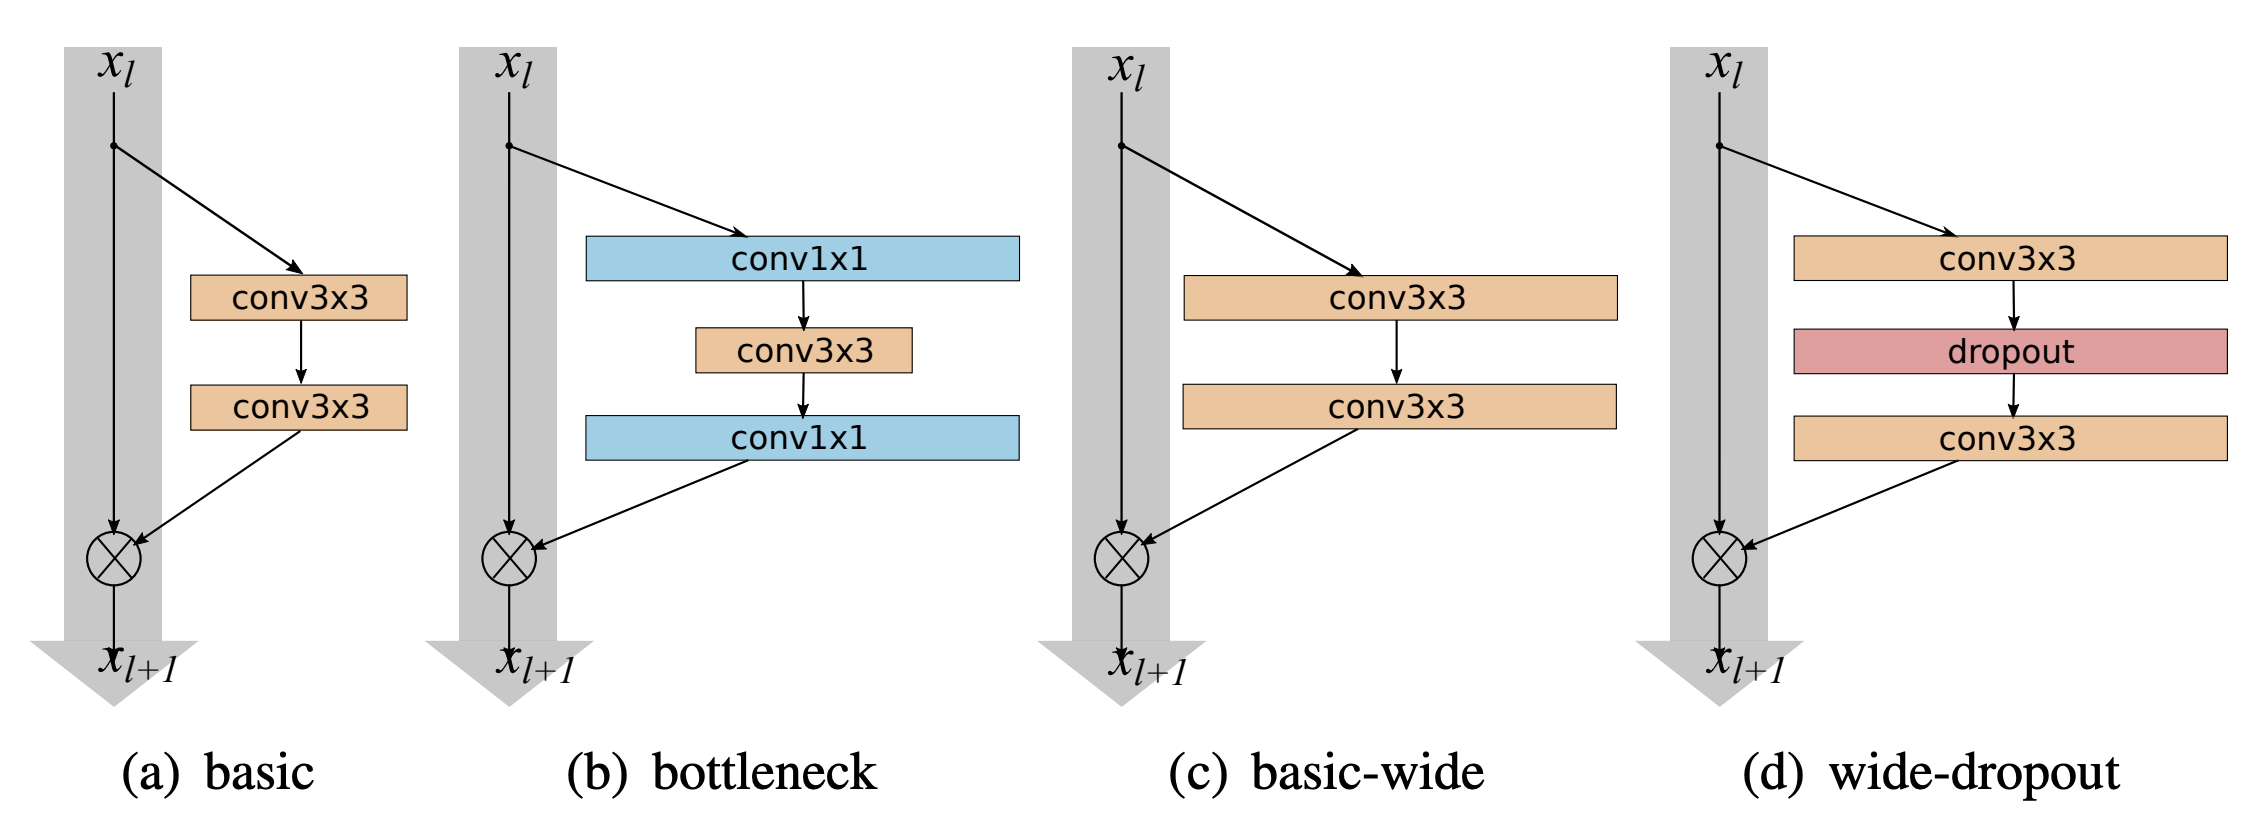

Figure 1: *Various ResNet Blocks*

## Diminishing Feature Reuse

A **Residual block with a identity mapping**, which allows us to train very deep networks is a **weakness**. As the gradient flows through the network there is nothing to force it to go through the residual block weights and thus it can avoid learning during training. This only a few blocks can run valuable representations or many blocks could share very little information with small contributions to the final goal. This problem was tried to be addressed using a special case of dropout applied to residual blocks in which an identity scalar weight is added to each residual block on which dropout is applied.

As we are widening our residual blocks, this results in an increase in the number of parameters, and the authors decided to study the effects of dropout to regularize training and prevent overfitting. They argued that the dropout should be inserted between convolutional layers instead of being inserted in the identity part of the block and showed that this results in consistent gains, yielding new SOTA results.

The paper [Wide Residual Networks](https://arxiv.org/pdf/1605.07146.pdf) attemptsto answer the question of how wide deep residual networks should be and address the problem of training.

# Residual Networks

$\large 
x_{l+1} = x_l + \mathbb{F}(x_l, W_l)
$


This is the representation of a Residual block with an identity mapping. 

* $x_{l+1}$ and $x_l$ represent the input and output of the $l$-th unit in the network

* $\mathbb{F}$ is a residual function

* $W_l$ are the parameters

Figure 1(a) and 1(c) represent the fundamental difference between the *basic* and the *basic-wide* blocks used.

# Architecture

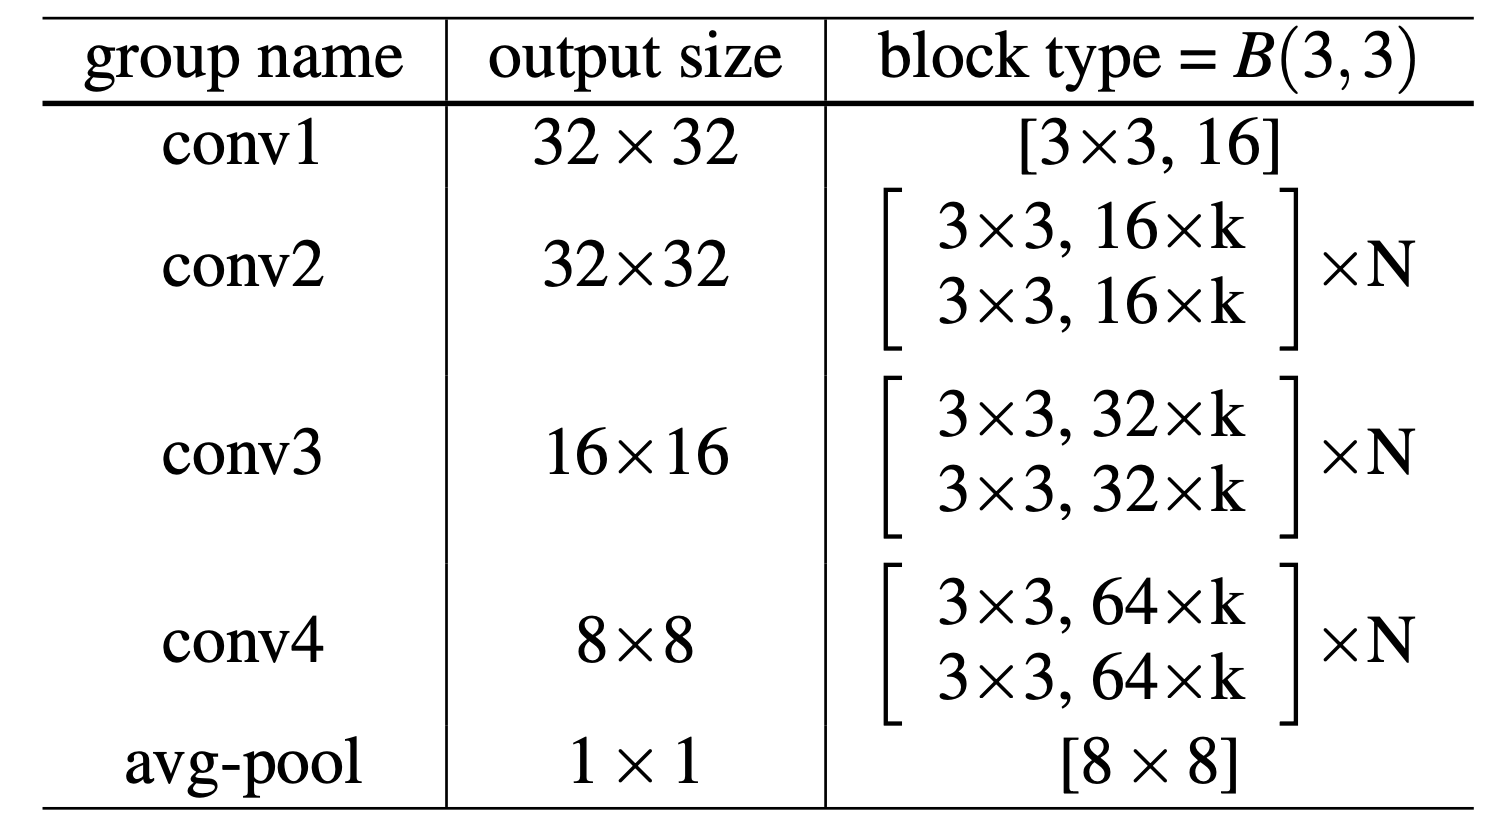

This is the basic structure of Wide Residual Networks. In the papers the size of `conv1` was fixed in all the experiments, while the "widening" factor `k` was experimented with in the next three groups. Here `k` is the. widening factor which multiplies the number of features in convolutional layers

Let B(M) denote various residual block structures, where M is a list with the kernel sizes of the convoutional layers in a block.
The following architectures were used in experimentation:-

* B(3,3) - The Original "basic" block. (Figure 1(a))
* B(3,1,3) - Same as basic but with a extra 1x1 layer in between
* B(1,3,1) - For Bottleneck (Figure 1(b))
* B(1,3) - Having Alternative 1x1-3x3 convolutions
* B(3,1) - Having Alternative 3x3-1x1 convolutions
* B(3,1,1) - A Network-in-Network style block

# Experimental Results

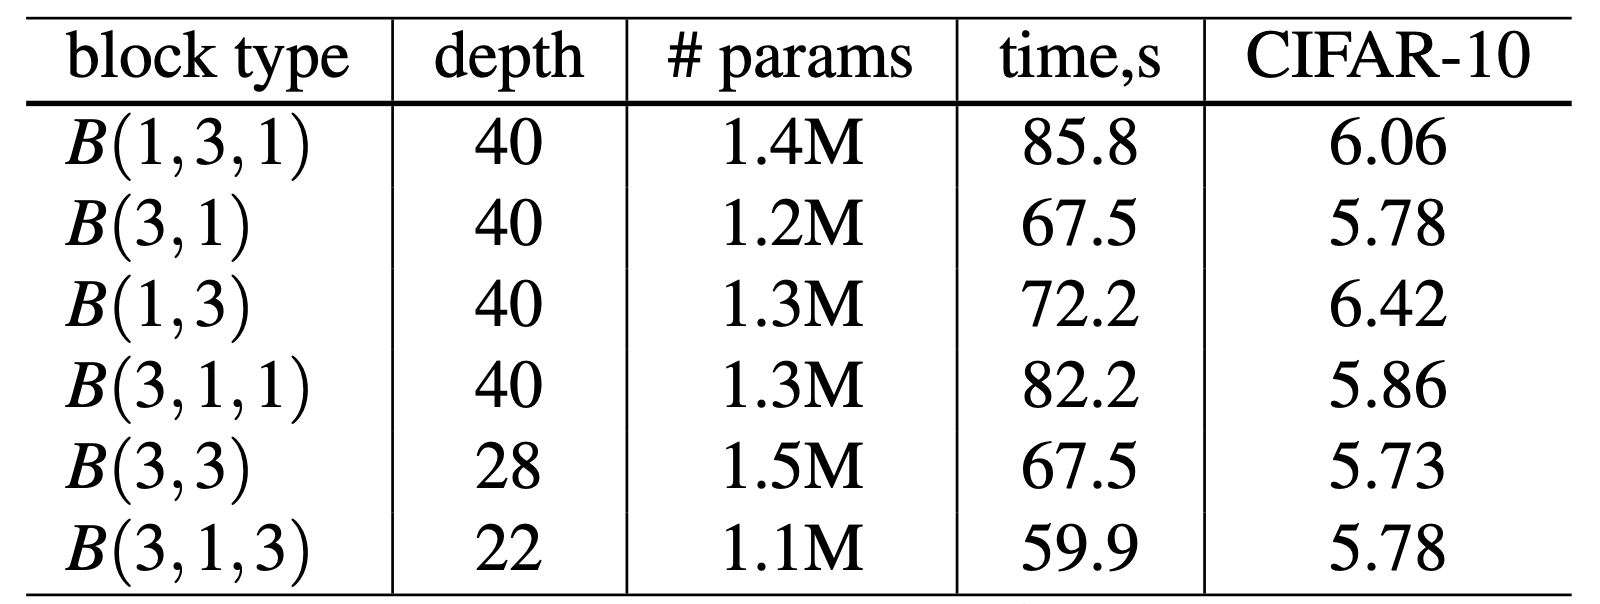

*Test error (%, median over 5 runs) on CIFAR-10 of residual networks with k = 1 and different block types. Time represents one training epoch*

The paper highlights that the block structure B(3,3) beats B(3,1) and B(3,1,3) by a little margin. 

# Key Takeaways

The paper highlights a method, giving a total improvement of 4.4% over ResNet-1001 and showing that:-

* widening consistently improves performance across residual networks of different depth

* incresing both depth and width helps until the number of parameters becomes too high and stronger regularization is required

* there doesn't seem to be a regularization effect from very high depth in residual networks as wide networks with the same number of parameters as thin ones can learn same or better representations. Furthermore, wide networks can successfully learn with a 2 or more times larger number of parameters than thin ones, which would require doubling the depth of thin networks, making them infeasibly expensive to train.

# Importing Libraries

In [ ]:
import trax
from trax import layers as tl
from trax.supervised import training

# Trax offers the WideResnet architecture in it's models module
from trax.models.resnet import WideResnet

trax.fastmath.set_backend('tensorflow-numpy')

# Downloading Dataset

Trax offers a rich collection of [.data](https://trax-ml.readthedocs.io/en/latest/trax.data.html) API's to create input pipelines. One of which is the [`trax.data.TFDS()`](https://trax-ml.readthedocs.io/en/latest/trax.data.html#trax.data.tf_inputs.TFDS) which returns an iterator of numpy arrays representing the dataset. 

If you'd like to learn more about the trax.data API's please checkout the notebook [here](https://www.kaggle.com/sauravmaheshkar/trax-data-explained) where I explain the most common API's in a in-depth manner

In [ ]:
%%capture
train_stream = trax.data.TFDS('cifar10', keys=('image', 'label'), train=True)()
eval_stream = trax.data.TFDS('cifar10', keys=('image', 'label'), train=False)()

# Batch Generator

Here, we create pre-processing pipelines, by using the [`Shuffle()`](https://trax-ml.readthedocs.io/en/latest/trax.data.html#trax.data.inputs.Shuffle), [`Batch()`](https://trax-ml.readthedocs.io/en/latest/trax.data.html#trax.data.inputs.Batch) and [`AddLossWeights()`](https://trax-ml.readthedocs.io/en/latest/trax.data.html#trax.data.inputs.AddLossWeights) functions from the trax.data API

In [ ]:
train_data_pipeline = trax.data.Serial(
    trax.data.Shuffle(),
    trax.data.Batch(64),
    trax.data.AddLossWeights(),
)

train_batches_stream = train_data_pipeline(train_stream)

eval_data_pipeline = trax.data.Serial(
    trax.data.Batch(64),
    trax.data.AddLossWeights(),
)

eval_batches_stream = eval_data_pipeline(eval_stream)

# Model Architecture

We use the `WideResnet` architecture defined in `trax.models.resnet` module. By Default the "widening factor" is set to 1, thus we experiment with two values, 1 and 2. The Architecture doesn't contain a [`tl.LogSoftmax()`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.LogSoftmax) function so we add it to our model using the [`tl.Serial()`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Serial) combinator

In [ ]:
thin_model = tl.Serial(
    WideResnet(widen_factor = 1),
    tl.LogSoftmax()
)

wide_model = tl.Serial(
    WideResnet(widen_factor = 2),
    tl.LogSoftmax()
)

When we have our model and the data, we use [`trax.supervised.training`](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#module-trax.supervised.training) to define training and eval tasks and create a training loop. The Trax training loop optimizes training and will create TensorBoard logs and model checkpoints for you.

In [ ]:
train_task = training.TrainTask(
    labeled_data=train_batches_stream,
    loss_layer=tl.CrossEntropyLoss(),
    optimizer=trax.optimizers.Adam(0.01),
    n_steps_per_checkpoint=1000,
)

eval_task = training.EvalTask(
    labeled_data=eval_batches_stream,
    metrics=[tl.CrossEntropyLoss(), tl.Accuracy()],
    n_eval_batches=20,
)

In [ ]:
training_loop = training.Loop(thin_model, 
                              train_task, 
                              eval_tasks=[eval_task], 
                              output_dir='./thin_model')

training_loop.run(5000)


Step      1: Total number of trainable weights: 295866
Step      1: Ran 1 train steps in 18.14 secs
Step      1: train CrossEntropyLoss |  2.49250388
Step      1: eval  CrossEntropyLoss |  2.38415594
Step      1: eval          Accuracy |  0.14687500

Step   1000: Ran 999 train steps in 648.60 secs
Step   1000: train CrossEntropyLoss |  1.56840193
Step   1000: eval  CrossEntropyLoss |  1.32664271
Step   1000: eval          Accuracy |  0.51484375

Step   2000: Ran 1000 train steps in 616.66 secs
Step   2000: train CrossEntropyLoss |  1.17271507
Step   2000: eval  CrossEntropyLoss |  1.11862110
Step   2000: eval          Accuracy |  0.59843750

Step   3000: Ran 1000 train steps in 612.61 secs
Step   3000: train CrossEntropyLoss |  1.00170410
Step   3000: eval  CrossEntropyLoss |  0.99056525
Step   3000: eval          Accuracy |  0.63593750

Step   4000: Ran 1000 train steps in 606.28 secs
Step   4000: train CrossEntropyLoss |  0.89905792
Step   4000: eval  CrossEntropyLoss |  0.88028392


In [ ]:
training_loop = training.Loop(wide_model, 
                              train_task, 
                              eval_tasks=[eval_task], 
                              output_dir='./wide_model')

training_loop.run(5000)


Step      1: Total number of trainable weights: 1167242
Step      1: Ran 1 train steps in 16.27 secs
Step      1: train CrossEntropyLoss |  2.34743023
Step      1: eval  CrossEntropyLoss |  2.30782272
Step      1: eval          Accuracy |  0.15703125

Step   1000: Ran 999 train steps in 1385.02 secs
Step   1000: train CrossEntropyLoss |  1.55927908
Step   1000: eval  CrossEntropyLoss |  1.37345315
Step   1000: eval          Accuracy |  0.48046875

Step   2000: Ran 1000 train steps in 1348.40 secs
Step   2000: train CrossEntropyLoss |  1.20171380
Step   2000: eval  CrossEntropyLoss |  1.00589269
Step   2000: eval          Accuracy |  0.64375000

Step   3000: Ran 1000 train steps in 1361.62 secs
Step   3000: train CrossEntropyLoss |  0.98751819
Step   3000: eval  CrossEntropyLoss |  0.92049764
Step   3000: eval          Accuracy |  0.66640625

Step   4000: Ran 1000 train steps in 1355.99 secs
Step   4000: train CrossEntropyLoss |  0.86016709
Step   4000: eval  CrossEntropyLoss |  0.8837